In [2]:
import pickle
import matplotlib.pyplot as pl

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'
colors = [red, green, blue, yellow, darkblue]

In [3]:
output_dir = '/Users/tgordon/research/exomoons/JexoSim/output/'
filename = '/OOT_SNR_NIRSpec_BOTS_G140M_F100LP_Kepler-22 b_2020_11_09_1546_42.pickle'
result = pickle.load(open(output_dir + filename, 'rb'))
exp_time = result['exp_time'].value
nhours = 20

parts = filename.split('_')
instrument = parts[2]
mode = parts[3]
filt = parts[4]
disp = parts[5]
name = parts[6]
filt_disp = '{0}/{1}'.format(filt, disp)

wl = result['noise_dic']['All noise']['wl']
means = result['noise_dic']['All noise']['signal_mean_stack']
stds = result['noise_dic']['All noise']['signal_std_stack']

t = np.arange(0, nhours*60*60, exp_time)

In [12]:
for l in open(output_dir + '/OOT_SNR_NIRSpec_BOTS_G140M_F100LP_Kepler-22 b_2020_11_09_1546_42.pickle.txt').readlines():
    print(l)

===== Simulation values =====

 

Planet:  Kepler-22 b

Channel:  NIRSpec_BOTS_G140M_F100LP



Noise option:  All noise

 

Use saturation time?:  1.0

Sat time (to designated fraction of full well):  7.482821143415237 s sec

t_f:  0.902 sec

t_g:  0.902 sec

t_sim:  0.902 sec

subarray  :  SUB2048

saturation flag  :  0

saturation limit  :  52000.0 electrons

number of saturated pixels per image  :  0

zero values applied to saturated pixels  :  0.0

t_int:  6.314 sec

t_cycle:  8.118 sec

projected multiaccum (n groups):  8

effective multiaccum (n groups):  2

number of NDRs simulated:  2000

number of integration cycles:  1000

 

ApFactor:  6.0

Aperture shape:  rect

Spectral binning:  R-bin 

Binned R power:  100.0 

Wavelength: 0.97 1.86944

 

 ===== Copy of input parameters file used =====

 

 ######################### SIMULATION ################################################



sim_diagnostics      0

# 1 = see diagnostics. 0 = hide diagnostics.  Recommend 0.  

        

In [4]:
result

{'simulation_mode': 1.0,
 'simulation_realisations': 1.0,
 'ch': 'NIRSpec_BOTS_G140M_F100LP',
 'input_spec': <Quantity [0.        , 0.        , 0.        , ..., 0.00049419, 0.00049419,
            0.00049419]>,
 'input_spec_wl': <Quantity [0.56692071, 0.56755915, 0.5681976 , ..., 1.86889595, 1.86953002,
            1.87016409] um>,
 'exp_time': <Quantity 8.118 s>,
 'noise_dic': {'All noise': {'wl': array([0.57837336, 0.58418616, 0.59005738, 0.5959876 , 0.60197743,
          0.60802745, 0.61413828, 0.62031053, 0.6265448 , 0.63284173,
          0.63920195, 0.64562609, 0.6521148 , 0.65866872, 0.6652885 ,
          0.67197482, 0.67872833, 0.68554972, 0.69243967, 0.69939886,
          0.706428  , 0.71352778, 0.72069891, 0.72794212, 0.73525812,
          0.74264765, 0.75011144, 0.75765025, 0.76526482, 0.77295593,
          0.78072433, 0.78857081, 0.79649614, 0.80450113, 0.81258656,
          0.82075326, 0.82900204, 0.83733372, 0.84574913, 0.85424912,
          0.86283454, 0.87150625, 0.88026

In [94]:
# simulate a time-series representing the covering fraction of the cold photosphere component 

import celerite2
from celerite2 import terms

S0 = 2e-11
w0 = 886
term = terms.SHOTerm(S0=S0, w0=w0, Q=1/np.sqrt(2))
gp = celerite2.GaussianProcess(term, mean=0.0)
gp.compute(t/(60*60*24), yerr = 0)
fk = (gp.dot_tril(np.random.randn(len(t))) + 1)

In [95]:
import sys
sys.path.append('../../notebooks/')
import generate_noise
import imp
imp.reload(generate_noise)

factors, data, wl = generate_noise.variability_factors(fk, wl, cold_temp=5500, hot_temp=5600, effective_temp=5500, spec_path='../../JexoSim/archive')

../../notebooks/generate_noise.py:40: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  flux_hot_kep = quad(int_hot_kep, np.min(kep_band[0])/1e3, np.max(kep_band[0])/1e3)
../../notebooks/generate_noise.py:41: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 

In [96]:
shot_noise = np.random.randn(len(wl), len(t))*stds[:, None]
noisy_lc = means[None, :]*factors.T + shot_noise.T
ppm = (np.sqrt(np.sum(stds ** 2)) / np.sum(means)) / np.sqrt(60 / np.mean(np.diff(t)))

# equal white-noise bins
nbins = 3
total_wn = np.sqrt(np.sum(stds ** 2))
wn_per_bin = total_wn / np.sqrt(nbins)

inds = [0]
j = 0
for i in range(nbins):
    sum_wn_squared = 0
    sum_mean = 0
    while (np.sqrt(sum_wn_squared) < wn_per_bin) & (j < len(stds)):
        sum_wn_squared += stds[j] ** 2
        j += 1
    inds.append(j)

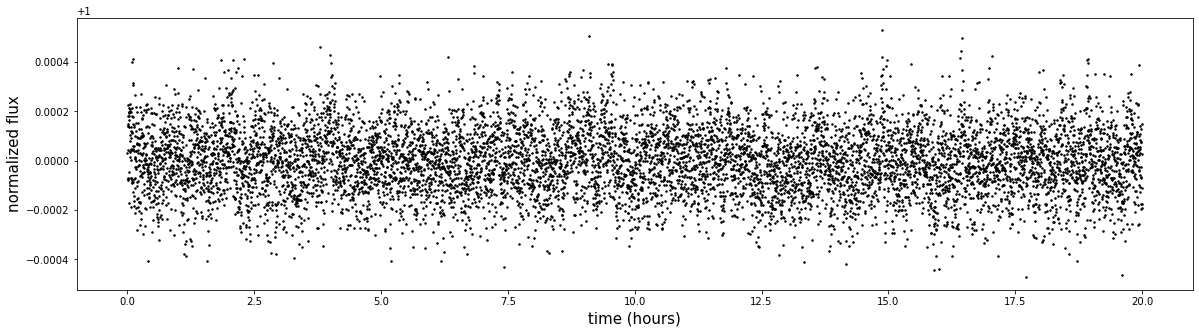

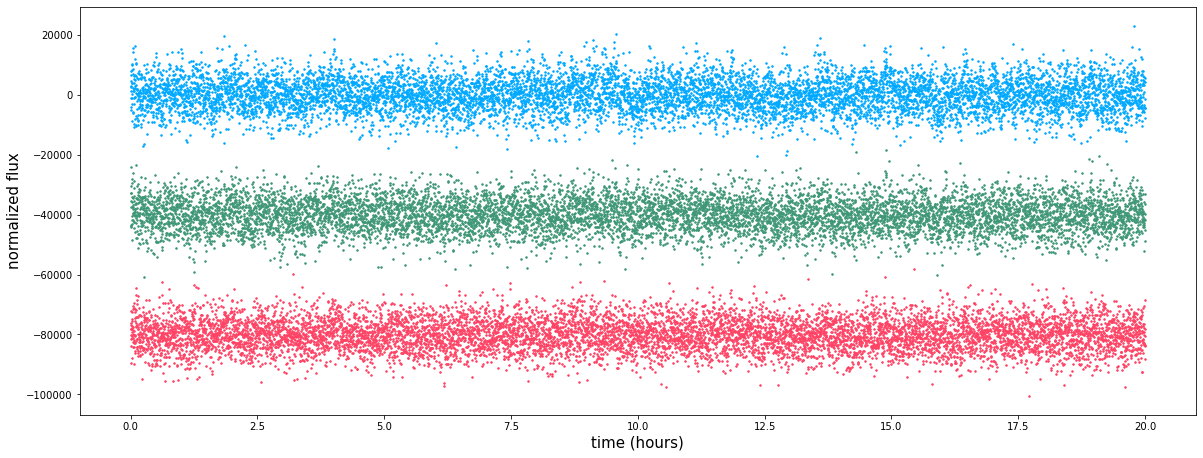

In [97]:
pl.figure(figsize=(20, 5))
monochrome = np.sum(noisy_lc, axis=1)

lcs = np.zeros((len(t), len(inds)-1))
for i in range(len(inds)-1):
    lcs[:, i] = np.sum(noisy_lc[:, inds[i]:inds[i+1]], axis=1)
pl.plot(t/(60*60), monochrome/np.mean(monochrome), 'k.', alpha=1, ms=3)
pl.ylabel("normalized flux", fontsize=15)
pl.xlabel("time (hours)", fontsize=15)
pl.savefig("/Users/tgordon/Desktop/monoflux.pdf")

pl.figure(figsize=(20, 7.5))
for i in range(len(inds)-1):
    pl.plot(t/(60*60), lcs[:, i] - np.mean(lcs[:, i]) - 40000 * i, '.', alpha=1, color=colors[2-i], ms=3)
pl.ylabel("normalized flux", fontsize=15)
pl.xlabel("time (hours)", fontsize=15)
pl.savefig("/Users/tgordon/Desktop/multiflux.pdf")

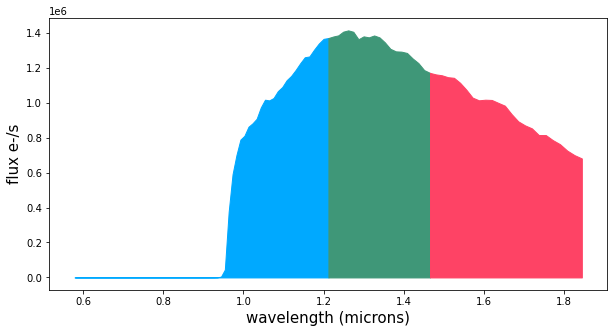

In [98]:
pl.figure(figsize=(10, 5))

for i in range(len(inds)-1):
    pl.fill_between(wl[inds[i]:inds[i+1]+1], means[0:][inds[i]:inds[i+1]+1], color=colors[2-i])
    
pl.xlabel('wavelength (microns)', fontsize=15)
pl.ylabel('flux e-/s', fontsize=15)
pl.savefig("/Users/tgordon/Desktop/spec.pdf")

In [61]:
import exoplanet as xo
orbit = xo.orbits.SimpleTransitOrbit(period=5*60*60, duration=5)
u = [0.3, 0.2]
rp = 0.0203
rm = 0.02
t0p = 15
t0m = 5
rstar = 0.98
dt = 6.977
#P = 2*np.pi*
planet = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=rp, t=t/(60*60) - t0p, texp=np.mean(np.diff(t))/(60*60))
    .eval()
).T[0]
moon = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=rm , t=t/(60*60) - t0m, texp=np.mean(np.diff(t))/(60*60))
    .eval()
).T[0]

In [62]:
orbit.period.eval()

array(18000.)

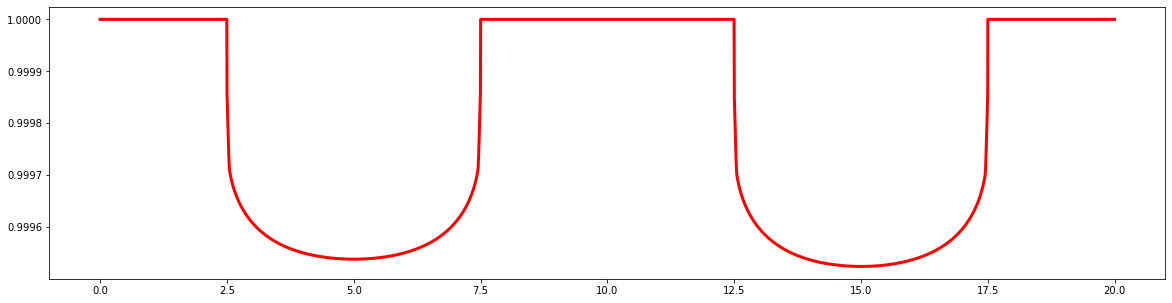

In [63]:
pl.figure(figsize=(20, 5))
#pl.plot(t/(60*60), monochrome/np.mean(monochrome) + moon + planet, 'k.', alpha=0.3)
pl.plot(t/(60*60), moon+1+planet, linewidth=3, color='r')

In [133]:
from astropy.table import table

data = lcs + np.mean(lcs, axis=0)*moon[:, None]
data = table.QTable(data, names=["wavelength bin {0}".format(i) for i in range(len(data.T))])
data.add_column(t, name='time')
data.meta['name'] = name
data.meta['S0'] = S0
data.meta['w0'] = w0
data.meta['t0p'] = t0p
data.meta['t0m'] = t0m
data.meta['rp'] = rp
data.meta['rm'] = rm
data.meta['rstar'] = rstar
data.meta['noise_floor_ppm'] = ppm
data.meta['filt_disp'] = filt_disp
data.meta['mode'] = mode
data.write(name.replace(' ', "") + ".fits", format='fits', overwrite=True)

In [129]:
t.dtype

dtype('float64')

In [122]:
int("400")

400

array([0.0000000e+00, 8.1180000e+00, 1.6236000e+01, ..., 7.1982306e+04,
       7.1990424e+04, 7.1998542e+04])